<a href="https://colab.research.google.com/github/shereenm88/Data-Analysis-NanoDegree/blob/main/DCF_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
!pip install yfinance

In [3]:
# Define the ticker symbol for TSMC
ticker = 'TSM'
tsmc = yf.Ticker(ticker)

# Get historical data
hist_data = tsmc.history(period='5y')
print(hist_data.head())

# Retrieve financial statements
income_stmt = tsmc.financials
balance_sheet = tsmc.balance_sheet
cash_flow = tsmc.cashflow
print("Income Statement:\n", income_stmt)
print("Balance Sheet:\n", balance_sheet)
print("Cash Flow Statement:\n", cash_flow)

                                Open       High        Low      Close  \
Date                                                                    
2019-10-31 00:00:00-04:00  46.927505  46.963680  46.439147  46.692371   
2019-11-01 00:00:00-04:00  46.927497  47.117413  46.755669  47.117413   
2019-11-04 00:00:00-05:00  48.428752  48.645801  48.039875  48.374493   
2019-11-05 00:00:00-05:00  48.501108  48.808592  48.374497  48.428757   
2019-11-06 00:00:00-05:00  48.564414  48.609632  48.021793  48.510151   

                            Volume  Dividends  Stock Splits  
Date                                                         
2019-10-31 00:00:00-04:00  5140800        0.0           0.0  
2019-11-01 00:00:00-04:00  5226600        0.0           0.0  
2019-11-04 00:00:00-05:00  7233400        0.0           0.0  
2019-11-05 00:00:00-05:00  5287100        0.0           0.0  
2019-11-06 00:00:00-05:00  4545100        0.0           0.0  
Income Statement:
                                    

In [4]:
# Define key assumptions for each scenario
scenarios = {
    'best': {
        'revenue_growth': 0.15,
        'ebitda_margin': 0.55,
        'capex_percent_revenue': 0.30,
        'working_cap_percent_revenue': 0.05,
        'tax_rate': 0.10,
        'wacc': 0.08,
        'terminal_growth': 0.03
    },
    'base': {
        'revenue_growth': 0.10,
        'ebitda_margin': 0.50,
        'capex_percent_revenue': 0.32,
        'working_cap_percent_revenue': 0.07,
        'tax_rate': 0.12,
        'wacc': 0.09,
        'terminal_growth': 0.025
    },
    'worst': {
        'revenue_growth': 0.05,
        'ebitda_margin': 0.45,
        'capex_percent_revenue': 0.35,
        'working_cap_percent_revenue': 0.10,
        'tax_rate': 0.15,
        'wacc': 0.10,
        'terminal_growth': 0.02
    }
}


In [5]:
# Set the initial revenue
initial_revenue = income_stmt.loc['Total Revenue'][0]  # Using latest revenue value

# Define function for DCF projections
def project_cash_flows(scenario, years=5):
    revenue = initial_revenue
    cash_flows = []

    for year in range(1, years + 1):
        revenue *= (1 + scenario['revenue_growth'])  # Revenue growth
        ebitda = revenue * scenario['ebitda_margin']  # Calculate EBITDA
        ebit = ebitda - revenue * 0.10  # Assume 10% D&A as a proxy
        nopat = ebit * (1 - scenario['tax_rate'])  # Calculate NOPAT
        capex = revenue * scenario['capex_percent_revenue']  # CapEx projection
        change_in_wc = revenue * scenario['working_cap_percent_revenue']  # WC projection

        # Calculate FCF
        fcf = nopat + (revenue * 0.10) - capex - change_in_wc  # D&A added back
        cash_flows.append(fcf)

    return cash_flows

# Generate FCF projections for each scenario
fcf_best = project_cash_flows(scenarios['best'])
fcf_base = project_cash_flows(scenarios['base'])
fcf_worst = project_cash_flows(scenarios['worst'])

# Display projected FCFs
print("Best Case FCFs:", fcf_best)
print("Base Case FCFs:", fcf_base)
print("Worst Case FCFs:", fcf_worst)

Best Case FCFs: [385329406350.0, 443128817302.50024, 509598139897.8749, 586037860882.5562, 673943540014.9398]
Base Case FCFs: [147430381559.99997, 162173419715.99997, 178390761687.60007, 196229837856.36002, 215852821641.99606]
Worst Case FCFs: [-119165685975.0, -125123970273.75, -131380168787.4375, -137949177226.80945, -144846636088.14978]


<ipython-input-5-2c5b95937ecb>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_revenue = income_stmt.loc['Total Revenue'][0]  # Using latest revenue value


In [6]:
# Function to calculate terminal value
def calculate_terminal_value(final_year_fcf, scenario):
    tv = final_year_fcf * (1 + scenario['terminal_growth']) / (scenario['wacc'] - scenario['terminal_growth'])
    return tv

# Function to calculate discounted cash flows
def calculate_dcf(cash_flows, scenario):
    dcf = 0
    for i, fcf in enumerate(cash_flows):
        dcf += fcf / ((1 + scenario['wacc']) ** (i + 1))  # Discount each FCF

    # Add terminal value
    terminal_value = calculate_terminal_value(cash_flows[-1], scenario)
    dcf += terminal_value / ((1 + scenario['wacc']) ** len(cash_flows))  # Discount TV

    return dcf

# Calculate DCF for each scenario
dcf_best = calculate_dcf(fcf_best, scenarios['best'])
dcf_base = calculate_dcf(fcf_base, scenarios['base'])
dcf_worst = calculate_dcf(fcf_worst, scenarios['worst'])

# Display DCF results
print(f"DCF Best Case: {dcf_best}")
print(f"DCF Base Case: {dcf_base}")
print(f"DCF Worst Case: {dcf_worst}")

DCF Best Case: 11479361201067.488
DCF Base Case: 2901067312932.6055
DCF Worst Case: -1641322208905.6929


In [8]:
# Check available labels in balance_sheet to see the exact column names
print(balance_sheet.columns)
print(balance_sheet.index)  # Check row names, which includes line items like 'Total Liab'


DatetimeIndex(['2023-12-31', '2022-12-31', '2021-12-31', '2020-12-31',
               '2019-12-31'],
              dtype='datetime64[ns]', freq=None)
Index(['Treasury Shares Number', 'Ordinary Shares Number', 'Share Issued',
       'Total Debt', 'Tangible Book Value', 'Invested Capital',
       'Working Capital', 'Net Tangible Assets', 'Capital Lease Obligations',
       'Common Stock Equity', 'Total Capitalization',
       'Total Equity Gross Minority Interest', 'Minority Interest',
       'Stockholders Equity', 'Other Equity Interest',
       'Gains Losses Not Affecting Retained Earnings',
       'Other Equity Adjustments', 'Treasury Stock', 'Retained Earnings',
       'Additional Paid In Capital', 'Capital Stock', 'Common Stock',
       'Total Liabilities Net Minority Interest',
       'Total Non Current Liabilities Net Minority Interest',
       'Other Non Current Liabilities', 'Employee Benefits',
       'Non Current Pension And Other Postretirement Benefit Plans',
       'Non Cur

In [11]:
# Net debt and shares outstanding
net_debt = balance_sheet.loc['Total Liabilities Net Minority Interest'][0] - balance_sheet.loc['Cash And Cash Equivalents'][0]
shares_outstanding = tsmc.info['sharesOutstanding']

# Calculate per-share values
def calculate_per_share_value(dcf_value, net_debt, shares_outstanding):
    equity_value = dcf_value - net_debt
    per_share_value = equity_value / shares_outstanding
    return per_share_value

# Per-share valuations for each scenario
per_share_best = calculate_per_share_value(dcf_best, net_debt, shares_outstanding)
per_share_base = calculate_per_share_value(dcf_base, net_debt, shares_outstanding)
per_share_worst = calculate_per_share_value(dcf_worst, net_debt, shares_outstanding)

print(f"Per-Share Value (Best): {per_share_best}")
print(f"Per-Share Value (Base): {per_share_base}")
print(f"Per-Share Value (Worst): {per_share_worst}")


<ipython-input-11-b291dddb8426>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  net_debt = balance_sheet.loc['Total Liabilities Net Minority Interest'][0] - balance_sheet.loc['Cash And Cash Equivalents'][0]


Per-Share Value (Best): 2095.312728972084
Per-Share Value (Base): 441.2128478317138
Per-Share Value (Worst): -434.66830827537945


In [12]:
# Create sensitivity analysis grid
wacc_range = np.arange(0.08, 0.12, 0.005)
tg_range = np.arange(0.02, 0.04, 0.005)

# Calculate sensitivity table
sensitivity_table = pd.DataFrame(index=tg_range, columns=wacc_range)
for wacc in wacc_range:
    for tg in tg_range:
        scenario = scenarios['base'].copy()
        scenario['wacc'] = wacc
        scenario['terminal_growth'] = tg
        dcf_val = calculate_dcf(fcf_base, scenario)
        per_share_val = calculate_per_share_value(dcf_val, net_debt, shares_outstanding)
        sensitivity_table.loc[tg, wacc] = per_share_val

print("Sensitivity Analysis Table:")
print(sensitivity_table)


Sensitivity Analysis Table:
            0.080       0.085       0.090       0.095       0.100       0.105  \
0.020  499.953066  450.862386  408.810897  372.390177  340.543924  312.464393   
0.025  546.306251  489.366309  441.212848  399.962463  364.234006  332.991631   
0.030  601.930074  534.870946  479.015124  431.776638  391.308384  356.255834   
0.035  669.914745   589.47651   523.69054  468.893176  422.548052  382.843495   

            0.110       0.115  
0.020  287.523349  265.224831  
0.025  305.443233  280.972742  
0.030  325.603102  298.573349  
0.035  348.450954  318.374031  


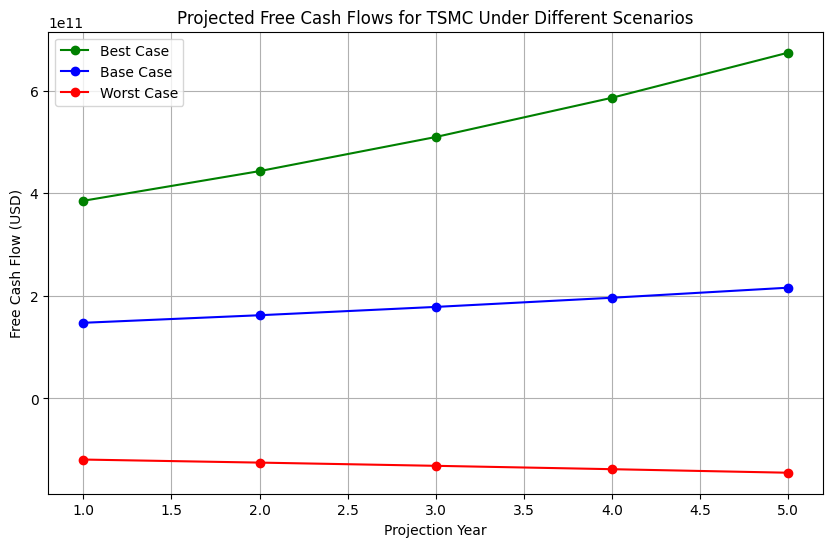

In [13]:
# Importing matplotlib for visualization
import matplotlib.pyplot as plt

# Define the years for the projection period
years = list(range(1, len(fcf_best) + 1))

# Plot the FCFs for each scenario
plt.figure(figsize=(10, 6))
plt.plot(years, fcf_best, label='Best Case', marker='o', color='green')
plt.plot(years, fcf_base, label='Base Case', marker='o', color='blue')
plt.plot(years, fcf_worst, label='Worst Case', marker='o', color='red')

# Adding labels and title
plt.xlabel('Projection Year')
plt.ylabel('Free Cash Flow (USD)')
plt.title('Projected Free Cash Flows for TSMC Under Different Scenarios')
plt.legend()
plt.grid(True)
plt.show()


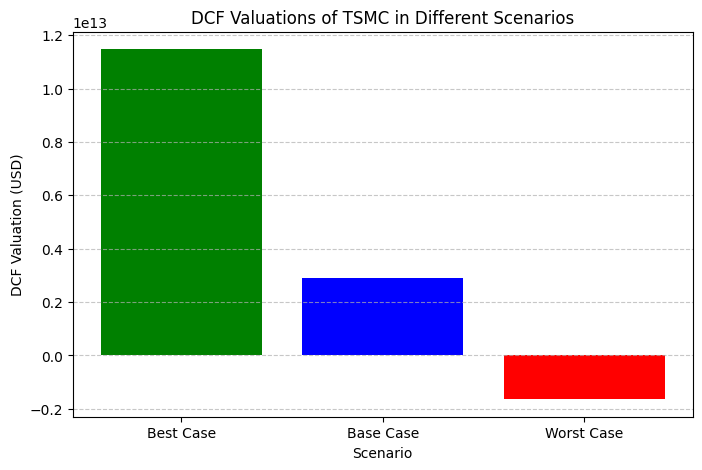

In [14]:
# Define DCF values for each scenario
dcf_values = [dcf_best, dcf_base, dcf_worst]
scenario_labels = ['Best Case', 'Base Case', 'Worst Case']
colors = ['green', 'blue', 'red']

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(scenario_labels, dcf_values, color=colors)

# Adding labels and title
plt.xlabel('Scenario')
plt.ylabel('DCF Valuation (USD)')
plt.title('DCF Valuations of TSMC in Different Scenarios')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


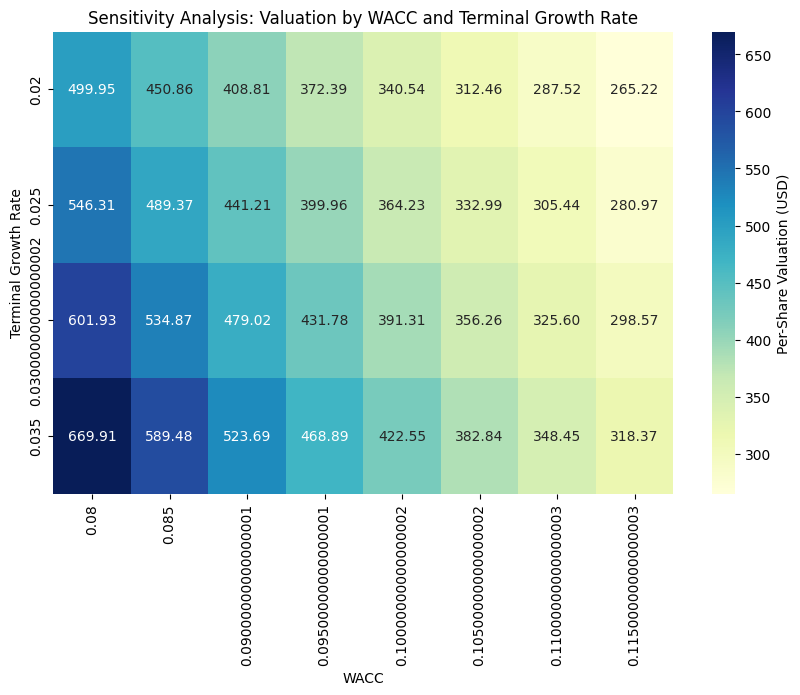

In [15]:
import seaborn as sns

# Ensure the sensitivity_table has numeric values only
sensitivity_table = sensitivity_table.astype(float)

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sensitivity_table, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Per-Share Valuation (USD)'})
plt.title('Sensitivity Analysis: Valuation by WACC and Terminal Growth Rate')
plt.xlabel('WACC')
plt.ylabel('Terminal Growth Rate')
plt.show()
